# Classificacao com modelos diversos, usando Ensemble

Reconhecimento de mal de parkinson atraves da voz.

Veja [aqui](https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification) os detalhes sobre o **dataset** utilizado.


# Todos os imports

In [1]:
import requests
from io import StringIO
from sklearn import naive_bayes, svm, tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,  roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from sklearn.model_selection import RandomizedSearchCV

# Load

In [2]:
dwn_url='https://drive.google.com/uc?export=download&id=1gQzKI5pgJUZfO44hnAB-DMVI0pMpTUXU'
url = requests.get(dwn_url).text
csv_raw = StringIO(url)

df = pd.read_csv(csv_raw, header=1) # inicia leitura na 2a linha
df.drop(['id'], 1, inplace=True) # remove coluna id
df.head()

<ipython-input-2-ce8030e5e542>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['id'], 1, inplace=True) # remove coluna id


,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [3]:
df['class'].value_counts()

1    564
0    192
Name: class, dtype: int64

# Split

In [4]:
X = np.array(df.drop(['class'], axis=1))
y = np.array(df['class'])

In [5]:
X.shape

(756, 753)

In [6]:
y.shape

(756,)

# Standardization (Padronizacao)

In [7]:
scaler = StandardScaler()
Z = scaler.fit_transform(X)
print(Z.shape)

(756, 753)


# PCA

In [8]:
pca = PCA(n_components = 200)
Z_PCA = pca.fit_transform(Z)
Z = Z_PCA

In [9]:
print(Z_PCA.shape)

(756, 200)


# Split Data

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

# Geracao dos Modelos

In [11]:
from sklearn.metrics import classification_report

In [12]:
# NaiveBayes (GaussianNB)
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
predicted = gnb.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.41      0.30      0.35        40
           1       0.77      0.85      0.81       112

    accuracy                           0.70       152
   macro avg       0.59      0.57      0.58       152
weighted avg       0.68      0.70      0.69       152



In [13]:
# TODO!!
# BaggingClassifier (GaussianNB) 
gnb_bagging = BaggingClassifier(estimator=naive_bayes.GaussianNB(), max_samples = 1.0, max_features = 1.0, n_estimators = 10)
gnb_bagging.fit(X_train, y_train)
predicted = gnb_bagging.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.47      0.35      0.40        40
           1       0.79      0.86      0.82       112

    accuracy                           0.72       152
   macro avg       0.63      0.60      0.61       152
weighted avg       0.70      0.72      0.71       152



In [14]:
# SupportVectorMachine (SVC)
cls = svm.SVC(kernel='linear', probability=True)
cls.fit(X_train, y_train)
predicted = cls.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58        40
           1       0.84      0.88      0.86       112

    accuracy                           0.79       152
   macro avg       0.73      0.71      0.72       152
weighted avg       0.78      0.79      0.79       152



In [15]:
# DecisionTreeClassifier
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.57      0.42      0.49        40
           1       0.81      0.88      0.85       112

    accuracy                           0.76       152
   macro avg       0.69      0.65      0.67       152
weighted avg       0.75      0.76      0.75       152



In [16]:
# TODO!!
# VotingClassifier
voting = VotingClassifier(estimators = [
    ('NaiveBayes', naive_bayes.GaussianNB()), 
    ('Bagging', BaggingClassifier(estimator=naive_bayes.GaussianNB(), max_samples = 1.0, max_features = 1.0, n_estimators = 10)), 
    ('SVC', svm.SVC(kernel='linear', probability=True)), 
    ('DecisionTree', tree.DecisionTreeClassifier())
],
voting='soft', weights=[1, 1, 1, 1]) #

voting.fit(X_train, y_train)
predicted = voting.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.58      0.38      0.45        40
           1       0.80      0.90      0.85       112

    accuracy                           0.76       152
   macro avg       0.69      0.64      0.65       152
weighted avg       0.74      0.76      0.75       152



In [17]:
# StackingClassifier
estimators = [
    ('NaiveBayes', naive_bayes.GaussianNB()), 
    ('Bagging', BaggingClassifier(estimator=naive_bayes.GaussianNB(), max_samples = 1.0, max_features = 1.0, n_estimators = 10)), 
    ('SVC', svm.SVC(kernel='linear', probability=True)), 
    ('DecisionTree', tree.DecisionTreeClassifier())
]

clf = StackingClassifier(estimators=estimators, final_estimator=tree.DecisionTreeClassifier())
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.49      0.42      0.45        40
           1       0.80      0.84      0.82       112

    accuracy                           0.73       152
   macro avg       0.64      0.63      0.64       152
weighted avg       0.72      0.73      0.72       152



# Cross Validation (Para um Modelo)

### Cross Validation (Para um Modelo)

In [18]:
# TODO!!
model = svm.SVC(kernel='linear', probability=True)
scores = cross_val_score(model, Z, y, cv=5, scoring = 'f1')
score_mean = scores.mean()
print('{}, Score: {}'.format(model.__class__.__name__, score_mean))

SVC, Score: 0.8129577785123715


### Cross Validation (Para varios Modelos)

GaussianNB: 0.7993 (+/- 0.0177)
BaggingClassifier: 0.8082 (+/- 0.0214)
SVC: 0.8130 (+/- 0.0355)
DecisionTreeClassifier: 0.8143 (+/- 0.0145)


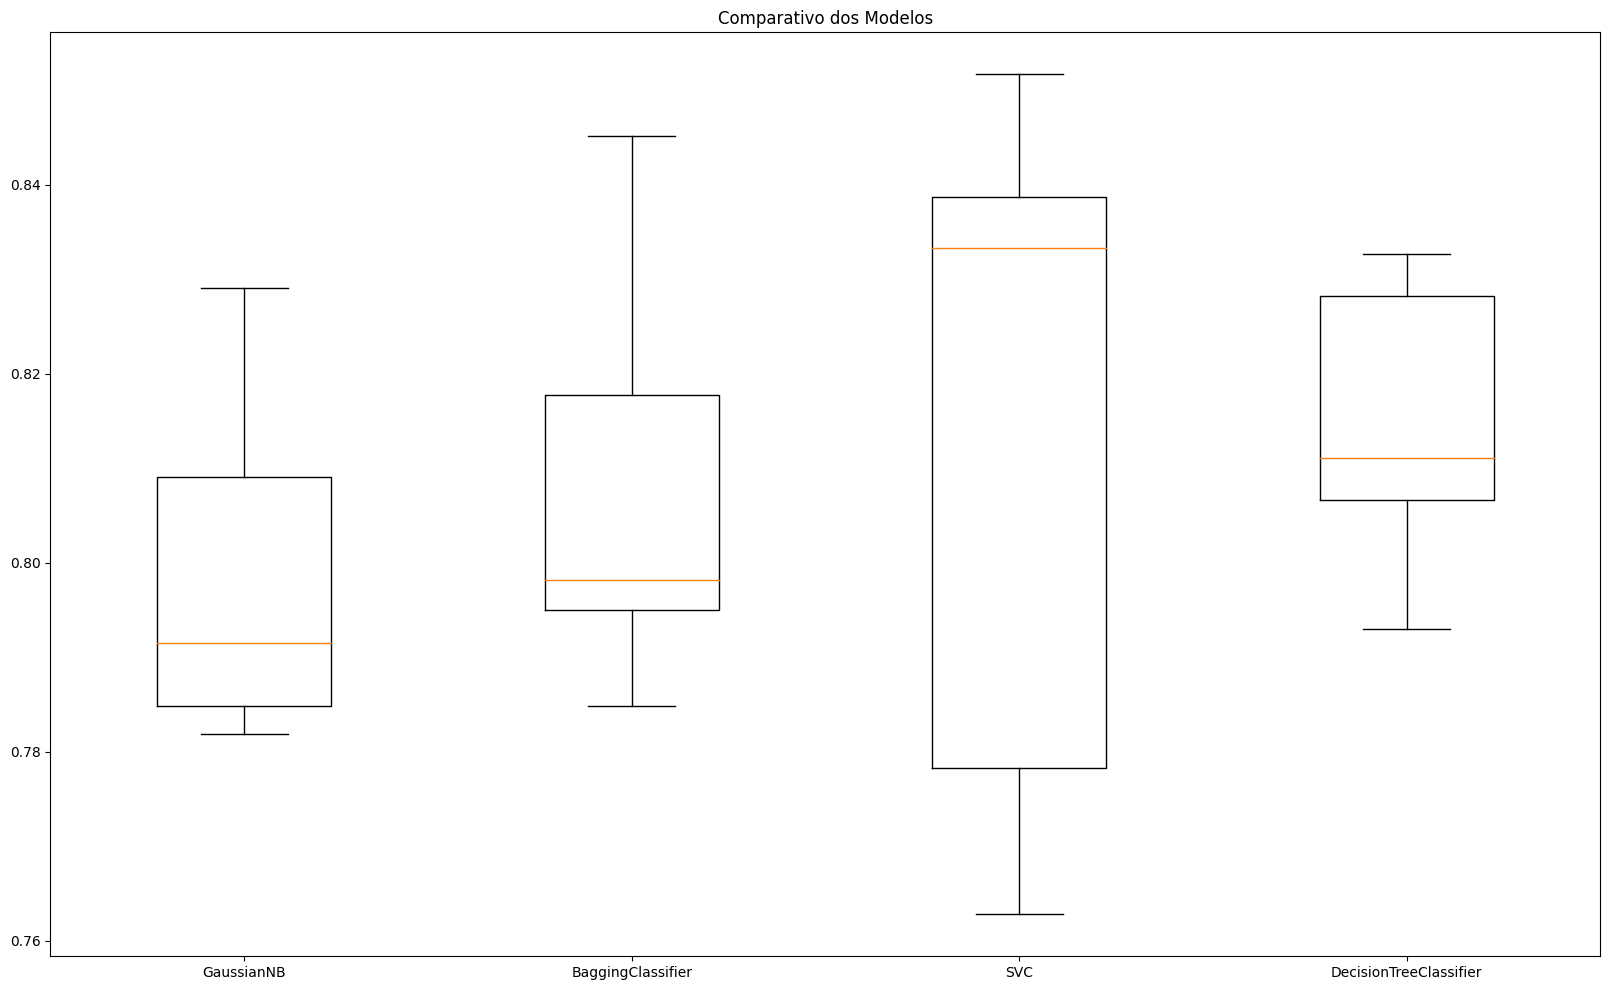

In [19]:
# modelos
models = [
    naive_bayes.GaussianNB(), 
    BaggingClassifier(estimator=naive_bayes.GaussianNB(), max_samples = 1.0, max_features = 1.0, n_estimators = 10), 
    svm.SVC(kernel='linear', probability=True), 
    tree.DecisionTreeClassifier()
] #TODO!!

results = []
names = []

fig = plt.figure(figsize=(20,12))

for model in models: #Validacao Cruzada #TODO!!
  cv_results = cross_val_score(model, Z, y, cv=5, scoring = 'f1')
  results.append(cv_results)
  names.append(model.__class__.__name__)
  print('{}: {:.4f} (+/- {:.4f})'.format(model.__class__.__name__, cv_results.mean(), cv_results.std()))
    
# Comparacao Visual dos Algoritmos
plt.boxplot(results, labels=names)
plt.title('Comparativo dos Modelos')
plt.show()

# Comparativo dos Modelos (Curva ROC)

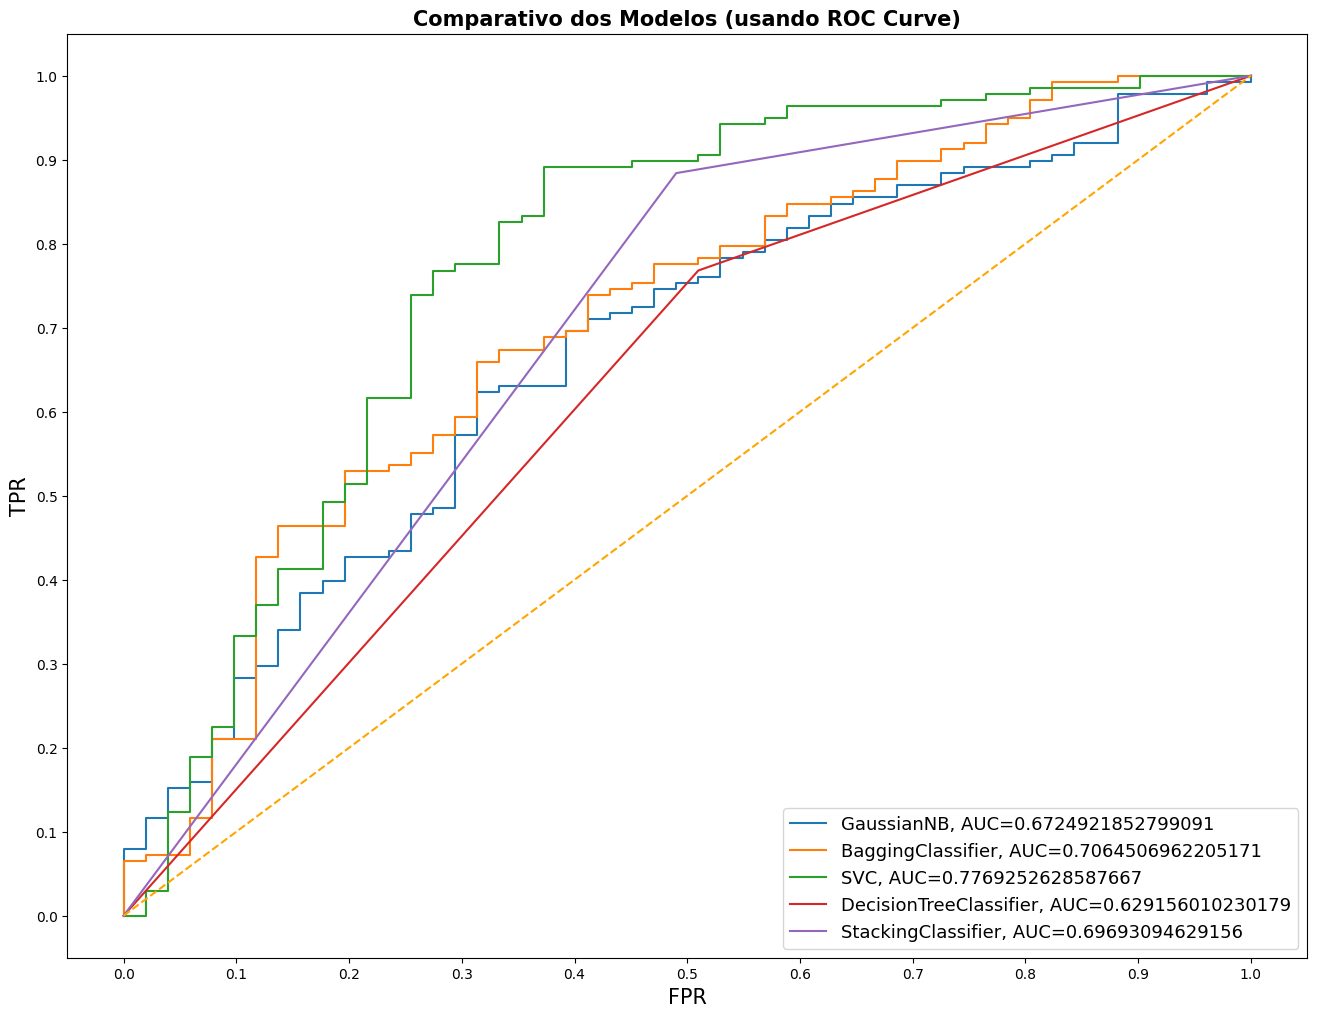

In [20]:
# classificadores a serem avaliados
models = [
    naive_bayes.GaussianNB(), 
    BaggingClassifier(estimator=naive_bayes.GaussianNB(), max_samples = 1.0, max_features = 1.0, n_estimators = 10), 
    svm.SVC(kernel='linear', probability=True), 
    tree.DecisionTreeClassifier(),
    StackingClassifier(estimators=estimators, final_estimator=tree.DecisionTreeClassifier())
] #TODO!!

X_train, X_test, y_train, y_test = train_test_split(Z, y, 
                                                    test_size=.25,
                                                    random_state=42)

# Treina os modelos a plota os resultados

fig = plt.figure(figsize=(16,12))

for model in models:
    model = model.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc_ = auc(fpr, tpr)
    
    plt.plot(fpr, 
             tpr, 
             label="{}, AUC={}".format(model.__class__.__name__, auc_))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("FPR", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("TPR", fontsize=15)

plt.title('Comparativo dos Modelos (usando ROC Curve)', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Última questão

Modifique o codigo implementado anteriormente, adicionando um novo ensemble a sua escolha, porem que contenha ao menos um modelo treinado com otimizacao de hiperametros (com RandomizedSearchCV).

Não é preciso adicionar nenhuma célula abaixo, basta modificar as células anteriores que se fizerem necessárias.

